In [216]:
from utils import *
from scipy.spatial.transform import Rotation as R


# Snake 2 Box
Lately i stumbled upon a 3D puzzle from a shop called [GAYA](https://gaya-game.co.il/collections/games-and-puzzles/products/product-18?variant=31635902915)

## The puzzle
The puzzle is devilishly simple – a 3x3x3 array of 27 wooden blocks all tied tightly together with a hidden elastic string.\
Each small block is either a "straight-through" piece (elastic emerges on opposite faces) or a "corner" piece (elastic emerges on two adjacent faces).\
The goal is to twist the blocks so that the 27 blocks form a cube… again.

![Figure 1.1 - Snake 2 Box](16603.jpeg)

After trying to solve this puzzle many times, testing diffrent approaches I couldn't find any other way than simulate this issue with Python.

## My Goals!
- Plan before execution, top-down solution.
- Get used to working with numpy and matplotlib.
- Solve this damn puzzle.

## Solution


### Defining the problem

In order to count the many variations our snake could be we need to use the 3D Field $\mathbb{N} ^3$\
We will represent each block as a vector over $\mathbb{N} ^3$.\
And lets set the location of the starting block to be our refrence point.
 
$\vec B_1= \left( 0 , 0 , 0 \right)$

Lets define a state to be a list of n such vectors.\
Our main goal is finding the solution state. $\bar S = B_1,B_2,...,B_{27}$ \
The solution state fills all of the points in 3x3x3.

### Counting possibilities

Now after we defined the problem, we can see that each block can be rotated into 4 diffrent states.\
That will affect the position of the blocks with higher index.\
Hence, we have $4^{25}$ possible states for this snicky snake.\
(we excluded the first and last blocks because rotating them is useless...).


### The states tree 

Let $T=\left(V,E\right)$ be a tree with the following structure:
- each vertex $v\in V$ will represent a state ($v=\left( \bar B_1, \bar B_2, ... \bar B_k \right)$) such that $dist\left( root,v\right) = k$.
- each edge $e=\left(u,v\right)\in E$ will represent an addition of one block (vaildly) from $u$ to $v$.

Our solution will be traversing the states tree until we will find our solution.


### Removing invalid possibilities from the states tree

In order to optimize our solution, on each depth step we will check if the addition is valid and remove the edge if not (hence, the snake is not only in the 3x3x3 box).




Lets visualize the states tree.


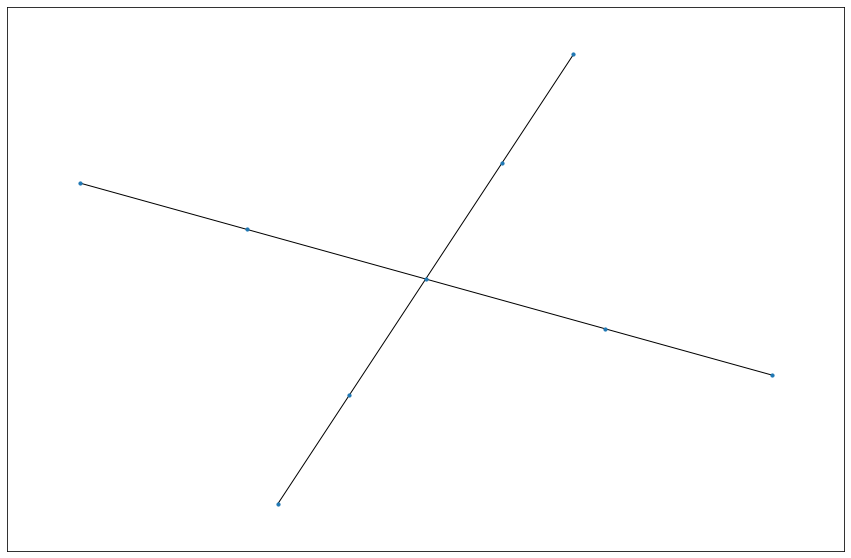

In [217]:
plt.rcParams['figure.figsize'] = [15, 10]

G = get_full_states_tree(3)#as 27 is to much to visualize 

G.visualize()



## Data structures

At first, we need to encode this real life puzzle into 1's and 0's.


### The Box modules

The Box module will represent the puzzle state in any step of the simulation.\
As mentioned above, each block can be "corner" or "straight".

A Box, will contain:
- The box *body*:\
    A 3x3x3 matrix used to record if a cell is occupied [0 -> empty or i -> block index]

The *body* in the beggining is empty.


In [218]:
class Box(object):
    def __init__(self):
        self.body = np.zeros((3,3,3),int)
    def validate_snake(self, snake) -> bool:
        for idx, state in enumerate(snake.state,start=1):
            if self.body[state[0]][state[1]][state[2]]:
                self.body = np.zeros((3,3,3),int)
                print(f"state {snake.state} is not valid.")
                print(f"found error in state {state}.")
                print(f"{self.body[state[0]][state[1]][state[2]]}")
                return False
            elif any([(x < 0 or x > 2) for x in state]):
                self.body = np.zeros((3,3,3),int)
                print(f"state {snake.state} is not valid.")
                print(f"found error in state {state}.")
                print(any([(x < 0 or x > 2) for x in state]))
                print([(x < 0 or x > 2) for x in state])
                return False
            else:
                self.body[state[0]][state[1]][state[2]] = idx
        return True
            
            



### The Snake module:

A Snake, will contain:
- A *defining array*:\
    such that each "corner" block will get 1 and "straight" will get 0.
    
In my case I have the *defining array* is:

$\left[0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0\right]$

## decoding option to states array



In [219]:
B = {
"x": np.array([1, 0, 0], int),
"y": np.array([0, 1, 0], int),
"z": np.array([0, 0, 1], int),
}

rots = {
"0": 0,
"1": 90,
"2": 180,
"3": 270
}
class Snake(object):
    def __init__(self,def_arr, option='00'):
        self.def_arr = def_arr
        self.option = option
        self.dir = B["x"]
        self.state = []
        self.state, _ = self.calc_states(option)


    def get_perpendicular_dir(self,dir):
        if abs(np.dot(dir, B["x"])) == 1:
            v = B["y"]
        elif abs(np.dot(dir, B["y"])) == 1:
            v = B["z"]
        elif abs(np.dot(dir, B["z"])) == 1:
            v = B["x"]
        return v

    def _get_next_dir(self, v, rotation):
        rotation_radians = np.radians(rotation)
        rotation_vector = rotation_radians * self.dir
        rotation = R.from_rotvec(rotation_vector)
        return np.array([round(x) for x in (rotation.apply(v))])

    def build_next_option(self, option):
        x = def_arr[len(self.state)]
        if x == 0:
            self.state.append(self.state[-1] + self.dir)
        elif x == 1:
            v = self.get_perpendicular_dir(self.dir)
            self.dir = self._get_next_dir(v, rots[option])
            self.state.append(self.state[-1] + self.dir)

    def calc_states(self,options:str) -> list:
        self.state = [np.array([0,0,0])]
        for op in options[1:]:
            self.build_next_option(op)
        return self.state.copy(), self.dir
    


### The OptionsTree module:

The Options Tree module will holds and maintains the possible options of the puzzle.

A Options Tree, will contain:
- A *options tree*:\
    The tree of possible states we are traversing. \
    The Options will be calculated dynamically.
    

In [220]:
class OptionsTree(object):
    def __init__(self):
        self.options = {'0':'00'}
    def addEdge(self, a, b):
        self.options[a] = b
    #TODO: add removeEdge method
    

In [221]:
class Puzzle:
    def __init__(self,def_arr):
        self.box = Box()
        self.snake = Snake(def_arr)
        self.tree = OptionsTree()
    def explore_dfs(self):
        visited = set()
        Q = [0,1,2,3] 
        op = '00'
        while True:
            try:
                next_option = op + str(Q.pop(0))
                print(f"trying to go from {op!r} to {next_option!r}")


                if not next_option in visited: 
                    visited.add(next_option)
                    self.snake.build_next_option(next_option[-1])
                    if self.box.validate_snake(self.snake):
                        self.tree.addEdge(op,next_option)
                        op = next_option
                        if len(op) == 5:
                            break
                        Q = [0, 1, 2, 3]
                    else:
                        self.snake.state.pop(-1)
            except IndexError:
                self.snake.state.pop(-1)
                op = op[:-1]

                

In [222]:
def_arr = [0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
puz = Puzzle(def_arr)
puz.explore_dfs()

trying to go from '00' to '000'
trying to go from '000' to '0000'
state [array([0, 0, 0]), array([0, 1, 0]), array([0, 1, 1]), array([1, 1, 1])] is not valid.
found error in state [0 0 0].
False
0
trying to go from '000' to '0001'
trying to go from '0001' to '00010'
state [array([0, 0, 0]), array([0, 1, 0]), array([0, 1, 1]), array([0, 1, 2]), array([1, 1, 2])] is not valid.
found error in state [0 0 0].
False
0
trying to go from '0001' to '00011'
trying to go from '000' to '0002'
state [array([0, 0, 0]), array([0, 1, 0]), array([0, 1, 1]), array([0, 1, 2]), array([-1,  1,  2])] is not valid.
found error in state [0 0 0].
False
0
trying to go from '000' to '0003'


IndexError: pop from empty list